In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [10]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
print(model.summary())

2024-05-04 23:22:26.226596: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-04 23:22:26.363960: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
directory = '/home/govind/Downloads/30k/flickr30k_images'
batch_size = 64  # You can adjust this based on your system's memory capacity

# Initialize an empty dictionary to store features
features = {}

# Iterate through images in batches
image_files = os.listdir(directory)
num_images = len(image_files)
num_batches = num_images // batch_size + (num_images % batch_size > 0)

for batch_idx in tqdm(range(num_batches)):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, num_images)
    
    batch_images = []
    batch_ids = []
    
    for img_name in image_files[start_idx:end_idx]:
        img_path = os.path.join(directory, img_name)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        batch_images.append(image)
        batch_ids.append(img_name.split('.')[0])
    
    batch_images = np.array(batch_images)
    batch_features = model.predict(batch_images, verbose=0)
    
    for i in range(len(batch_ids)):
        features[batch_ids[i]] = batch_features[i]

# Save features to a pickle file
with open('image_features.pkl', 'wb') as f:
    pickle.dump(features, f)

  0%|          | 0/497 [00:00<?, ?it/s]

In [11]:
file_path = 'image_features.pkl'

# Load features from the pickle file using a relative path
with open(file_path, 'rb') as f:
    features = pickle.load(f)

In [12]:
BASE_DIR = './'  # Assuming the file is in the same directory as your script or notebook
file_path = os.path.join(BASE_DIR, 'new.txt')  # Replace 'new.txt' with the actual file name

# Load features from the pickle file using a relative path
with open(file_path, 'r', encoding='latin-1') as f:
    next(f)  # Skip the first line if it contains headers or metadata
    captions_doc = f.read()

print("First few characters of captions_doc:")
print(captions_doc[:100])

First few characters of captions_doc:
1000092795.jpg,Two young guys with shaggy hair look at their hands while hanging out in the yard .
1


In [13]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/158915 [00:00<?, ?it/s]

In [64]:
len(mapping)

31783

Preprocess Text Data

In [14]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # remove start and end tags if present
            caption = caption.replace('startseq', '').replace('endseq', '').strip()
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.
            caption = ''.join(char for char in caption if char.isalnum() or char == ' ')
            # delete additional spaces
            caption = ' '.join(caption.split())
            # add start and end tags to the caption
            caption = 'startseq ' + caption + ' endseq'
            captions[i] = caption

In [15]:
# before preprocess of text
mapping['1000092795']

['Two young guys with shaggy hair look at their hands while hanging out in the yard .',
 'Two young  White males are outside near many bushes .',
 'Two men in green shirts are standing in a yard .',
 'A man in a blue shirt standing in a garden .',
 'Two friends enjoy time spent together .']

In [16]:
clean(mapping)

In [17]:
# after preprocess of text
mapping['1000092795']

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in a yard endseq',
 'startseq a man in a blue shirt standing in a garden endseq',
 'startseq two friends enjoy time spent together endseq']

In [18]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [70]:
len(all_captions)

158915

In [19]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [20]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [73]:
vocab_size

20012

In [24]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

80

# Train Test Split 

In [21]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.80)
train = image_ids[:split]
test = image_ids[split:]

In [22]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        batch_image_features = []
        batch_text_sequences = []
        batch_output_sequences = []
        
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    batch_image_features.append(features[key])
                    batch_text_sequences.append(in_seq)
                    batch_output_sequences.append(out_seq)
                    
                    if len(batch_image_features) == batch_size:
                        yield {
    "image": np.array(batch_image_features),  # No need to reshape
    "text": np.array(batch_text_sequences)
}, np.array(batch_output_sequences)
                        batch_image_features, batch_text_sequences, batch_output_sequences = [], [], []


# Model Creation

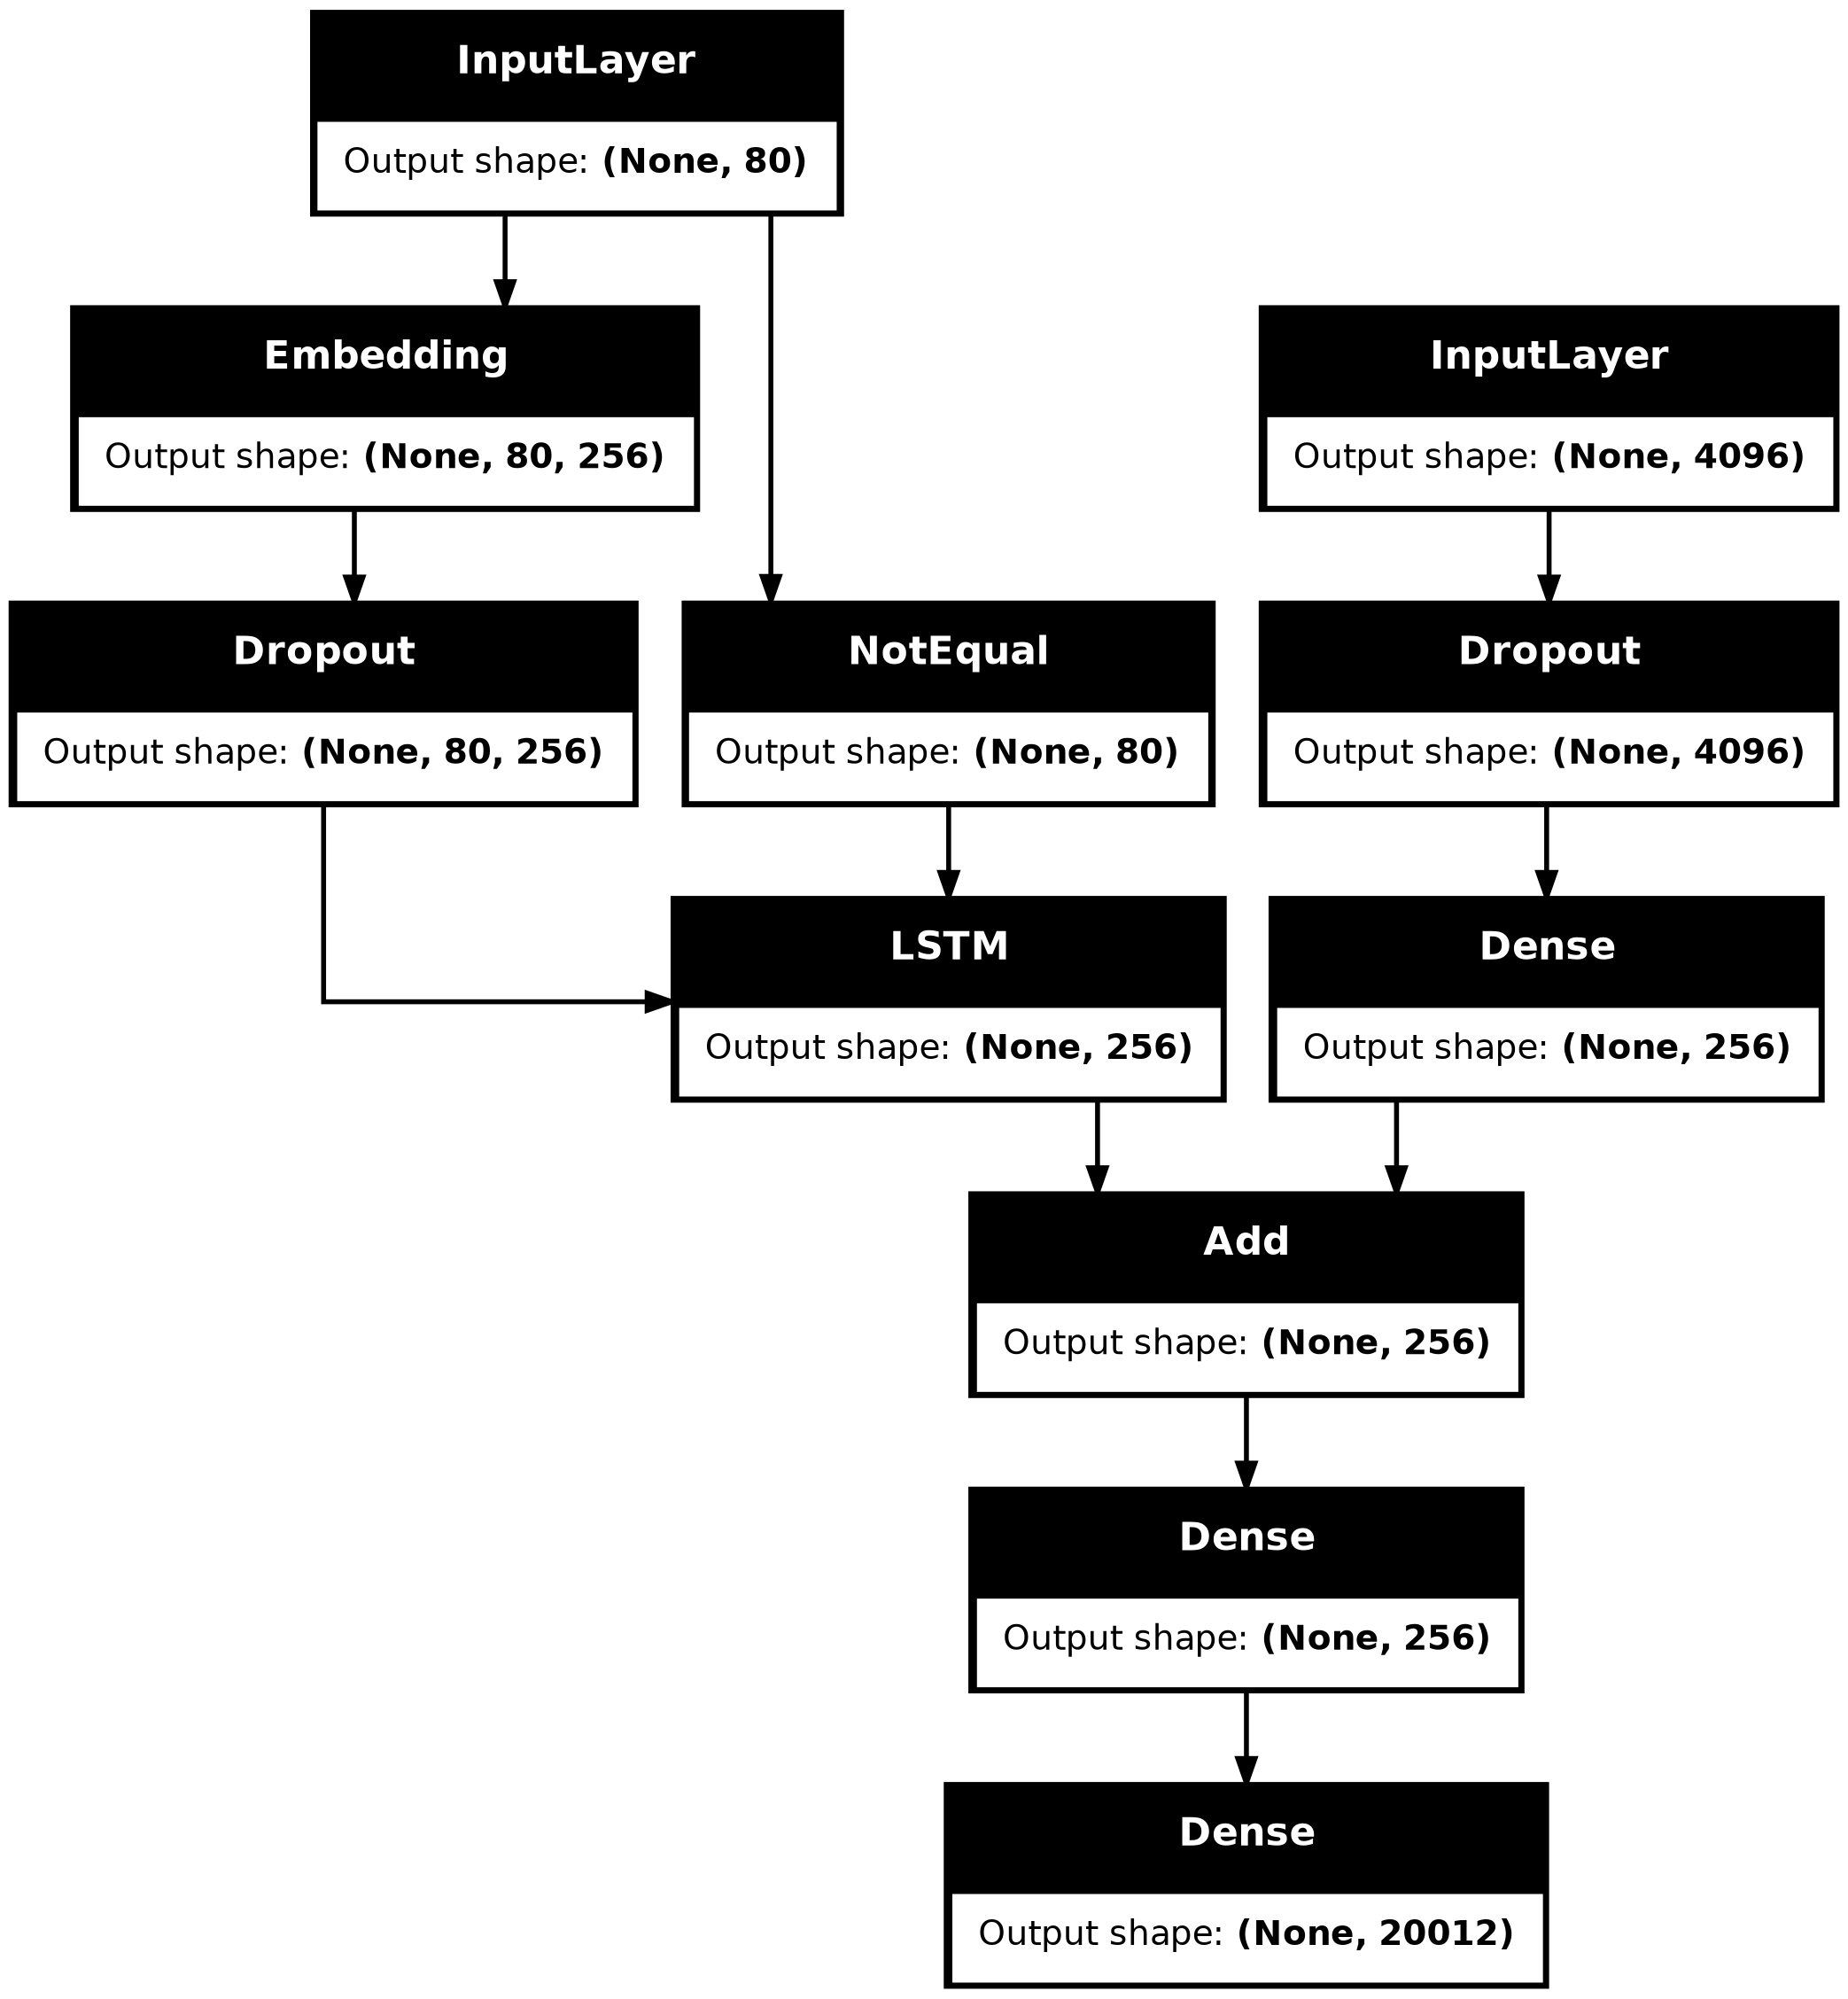

In [25]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)
# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
# plot the model
plot_model(model, show_shapes=True)

In [ ]:
epochs = 100
batch_size = 64
steps = len(train) // batch_size
for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)    
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


In [ ]:
direct = '/home/govind/Downloads/30k/'
model.save(direct+'fastest_model.keras')

In [50]:
import h5py
f = h5py.File('new_model.h5', 'r')
print(f.attrs.get('keras_version'))
print(f.attrs.get('tensorflow_version'))

3.0.5
None


In [28]:
import tensorflow as tf
model = tf.keras.models.load_model('my_model.keras')

In [29]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [30]:

def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        #yhat = model.predict([image, sequence], verbose=0)
        yhat = model.predict([np.expand_dims(image, axis=0), sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
            # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text


In [ ]:

from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()
for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))



In [31]:
from PIL import Image
import matplotlib.pyplot as plt
from gtts import gTTS
import os
import pygame
language = 'en'
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "flickr30k_images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
        # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    words = y_pred.split()  # split the text into a list of words
    words = words[1:-1]  # skip the first and last words
    mytext = ' '.join(words)
    myobj = gTTS(text=mytext, lang=language, slow=False)
    myobj.save("welcome.mp3")
    # Play the audio file using pygame
    pygame.mixer.init()
    pygame.mixer.music.load("welcome.mp3")
    pygame.mixer.music.play()

---------------------Actual---------------------
startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq
startseq two young white males are outside near many bushes endseq
startseq two men in green shirts are standing in a yard endseq
startseq a man in a blue shirt standing in a garden endseq
startseq two friends enjoy time spent together endseq


2024-05-04 23:25:03.712055: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


--------------------Predicted--------------------
startseq two young girls are standing on a garden look looking in a garden endseq


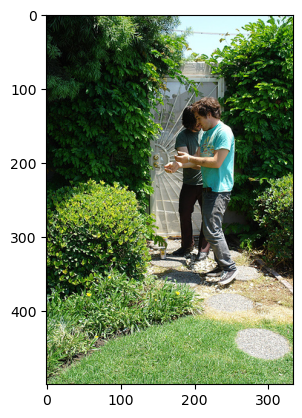

In [32]:
generate_caption("1000092795.jpg")

---------------------Actual---------------------
startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq
startseq a little girl in a pink dress going into a wooden cabin endseq
startseq a little girl climbing the stairs to her playhouse endseq
startseq a little girl climbing into a wooden playhouse endseq
startseq a girl going into a wooden building endseq
--------------------Predicted--------------------
startseq a girl in a pink dress going up a wooden wooden way up a wooden wooden way endseq


Gtk-Message: 02:00:15.770: Failed to load module "colorreload-gtk-module"
Gtk-Message: 02:00:15.771: Failed to load module "window-decorations-gtk-module"


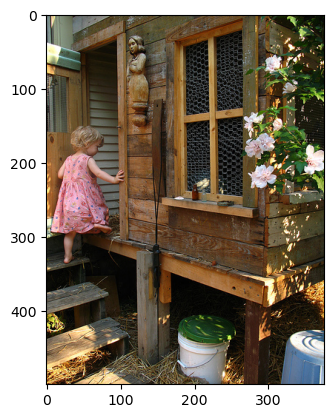

In [98]:
generate_caption("1000268201.jpg")

---------------------Actual---------------------
startseq a man with a red jacket is shielding himself from the sun trying to read a piece of paper endseq
startseq a man wearing a red coat is outside with his hand over his head to block out the sun endseq
startseq a man in a red jacket shades the sun from his eyes on a busy street endseq
startseq an elderly man in a red jacket shielding his face from the sun endseq
startseq man in red jacket shielding face from the sun to read endseq
--------------------Predicted--------------------
startseq a man is standing on the paper with a busy street endseq


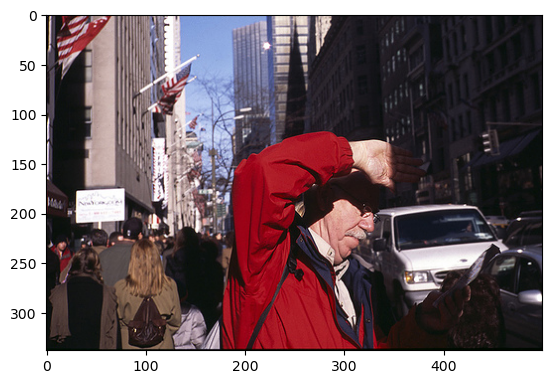

In [101]:
generate_caption("101471792.jpg")

---------------------Actual---------------------
startseq smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him endseq
startseq a little boy is standing on the street while a man in overalls is working on a stone wall endseq
startseq a young child is walking on a stone paved street with a metal pole and a man behind him endseq
startseq a boy smiles in front of a stony wall in a city endseq
startseq a young boy runs aross the street endseq
--------------------Predicted--------------------
startseq a boy in a blue shirt is climbing on a city sidewalk endseq


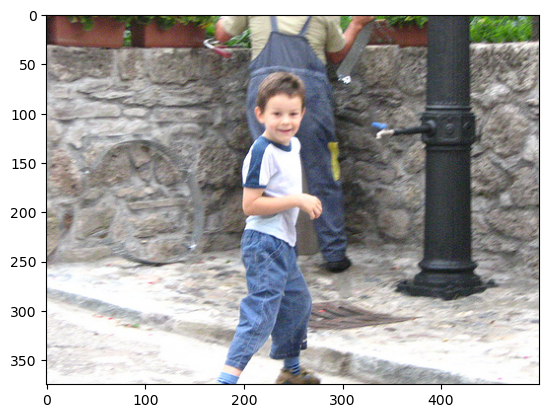

In [33]:
generate_caption("1015118661.jpg")

In [ ]:
import os
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

# Load the VGG16 model without the top (fully connected layers)
base_model = VGG16()
vgg_model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
print(model.summary())

# Path to the image you want to extract features from
image_path = '/home/govind/Downloads/30k/test.jpg'   # Update with the actual image path

# Load and preprocess the image
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)

# Extract features using the VGG16 model
features = vgg_model.predict(np.expand_dims(image, axis=0))
#features=model.predict(image,verbose=0)

features = features[0, ...]  # Access the first element (without batch dimension)
print(features.shape) 


def predict_caption2(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        #yhat = model.predict([image, sequence], verbose=0)
        yhat = model.predict([np.expand_dims(image, axis=0), sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
            # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text
model = tf.keras.models.load_model('my_model.keras')
captions=predict_caption2(model,features,tokenizer,max_length)
print(captions)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 80)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image (InputLayer)  │ (None, 4096)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 80, 256)   │  5,123,072 │ text[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 4096)      │          0 │ image[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 80, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 80)        │          0 │ text[0][0]        │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │  1,048,832 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_4[0][0],  │
│                     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense_3[0][0],    │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 20012)     │  5,143,084 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 35,718,278 (136.25 MB)

 Trainable params: 11,906,092 (45.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,812,186 (90.84 MB)

None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
(4096,)
startseq a happy boy is hugging on complex into a forrest preserve endseq
